In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import numpy.linalg as LA

In [2]:
from algorithms.meshforrectangle import MeshForRectangle

In [3]:
w = 1
h = 2
rectangle = [[0,0],[0,h],[w,h],[w,0]]
rectangle_area = 2

u = lambda x, y: (x - 1)**2 * (y - 2)**2 *x*y
a11 = 1
a22 = 1

f = lambda x, y: 2 * x * (x - 1)**2 * (3*y - 4) + 2*(3*x - 2)*(y - 2)**2 * y

beta = 1e-5
omega = 1e+5
psi = 0

$$
Input interpretation:
\frac{\partial^{2}\left((x-1)^{2}(y-2)^{2} x y\right)}{\partial x^{2}}+\frac{\partial^{2}\left((x-1)^{2}(y-2)^{2} x y\right)}{\partial y^{2}}
$$
$$
Result:
2 x(x-1)^{2}(3 y-4)+2(3 x-2)(y-2)^{2} y
$$


---
##### (d^2/dx^2  (x - 1)^2 * (y - 2)^2) + (d^2/dy^2 (x - 1)^2 * (y - 2)^2) )

In [4]:
nx = 10
ny = 20
mesher = MeshForRectangle(nx, ny)
triangulation = list(map(lambda t: t.get_points(), mesher.triangulate(rectangle)))

In [5]:
points = np.unique(np.concatenate(triangulation), axis=0).tolist()
triangles = list(map(lambda tri: [points.index(tri[0]),
                                  points.index(tri[1]),
                                  points.index(tri[2]),], triangulation))

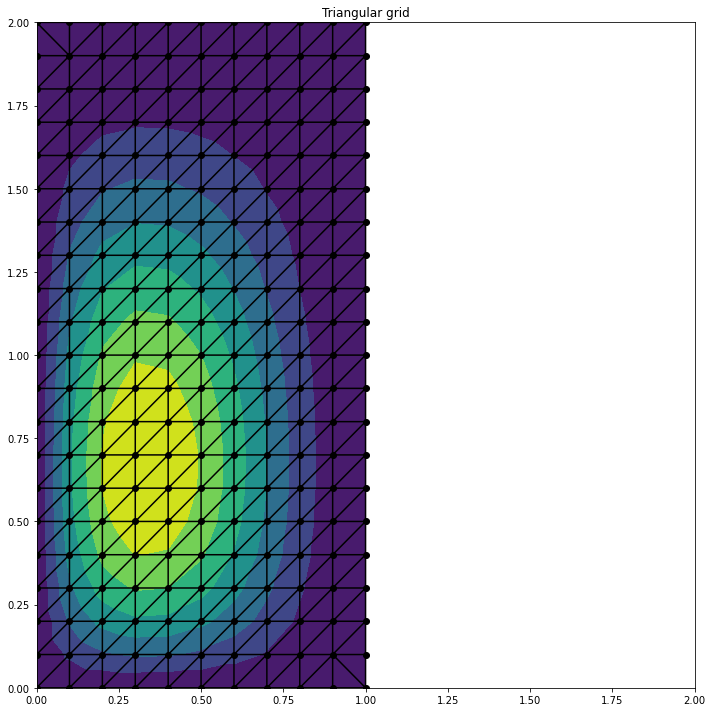

In [6]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
ax.tricontourf(triang, z)
ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')

fig.tight_layout()
plt.show()

In [7]:
n =  len(triangles)
triangle_area = rectangle_area / n
s = triangle_area

def K_i(b, c, s, a11, a22):
    K = np.zeros([3, 3])
    for i in range(3):
        for j in range(3):
            K[i][j] = (a11 * (b[i] * b[j]) + a22 * (c[i] * c[j]))

    K = K / (4 * s)
    return K


def fill_A_with_K_i(A, K, tri):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += K[i][j]
            
def fill_F_with_phi_i(F, tri, points=points, Me=[]):
    Qe = Me.dot(
        np.array([ [ f(*points[tri[0]]) ], [ f(*points[tri[1]]) ], [ f(*points[tri[2]]) ]])
    )

    for i in range(3):
        F[tri[i]] += Qe[i][0]


In [8]:
G = h / ny

Re = (omega*G)/(6*beta) * np.array([[2, 1], [1, 2]])
Pe = (psi*G)/(2*beta) * np.array([1, 1])
Me = -((s)/(14)) * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])

a = np.zeros([n, 3])
b = np.zeros([n, 3])
c = np.zeros([n, 3])
phi = np.zeros([n, 3])

A = np.zeros([len(points), len(points)])
F = np.zeros([len(points), 1])

for i, tri in enumerate(triangles):
    
    p1 = points[tri[0]]
    p2 = points[tri[1]] 
    p3 = points[tri[2]]
    
    boundary_points = np.array([])
    if sum(np.array([p1[0], p2[0], p3[0]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == 0]
    elif sum(np.array([p1[0], p2[0], p3[0]]).round(5) == w) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == w]        
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == 0]
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == h) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == h]

    if boundary_points.size:

        boundary_points = boundary_points.tolist()
        if p2 not in boundary_points:
            boundary_points.reverse()

        A[points.index(boundary_points[0])][points.index(boundary_points[0])] += Re[0][0]
        A[points.index(boundary_points[0])][points.index(boundary_points[1])] += Re[0][1]
        A[points.index(boundary_points[1])][points.index(boundary_points[0])] += Re[1][0]
        A[points.index(boundary_points[1])][points.index(boundary_points[1])] += Re[1][1]
        
        F[points.index(boundary_points[0])] += Pe[0]
        F[points.index(boundary_points[1])] += Pe[1]   
        continue
    
    p = [(p1[0] + p2[0] + p3[0])/3, (p1[1] + p2[1] + p3[1])/3] 
    
    groups = [
        (p2, p3, _), (p3, p1, _), (p1, p2, _)
    ]
    
    for j, group in enumerate(groups):
        t1 = group[0]
        t2 = group[1]
        
        b[i][j] = t2[1] - t1[1]
        c[i][j] = t2[0] - t1[0]
        
    K = K_i(b[i], c[i], s, a11, a22)
    fill_A_with_K_i(A, K, tri)
    fill_F_with_phi_i(F, tri, Me=Me)



In [9]:
b = LA.solve(A, F)

In [10]:
ex = [u(*p) for p in points]

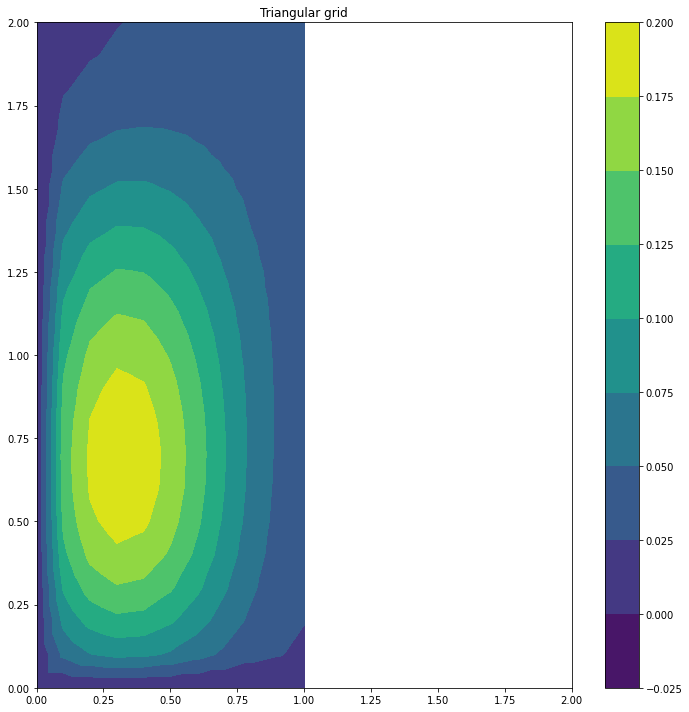

In [11]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = b.ravel()

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
fig.colorbar(cp)

# ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

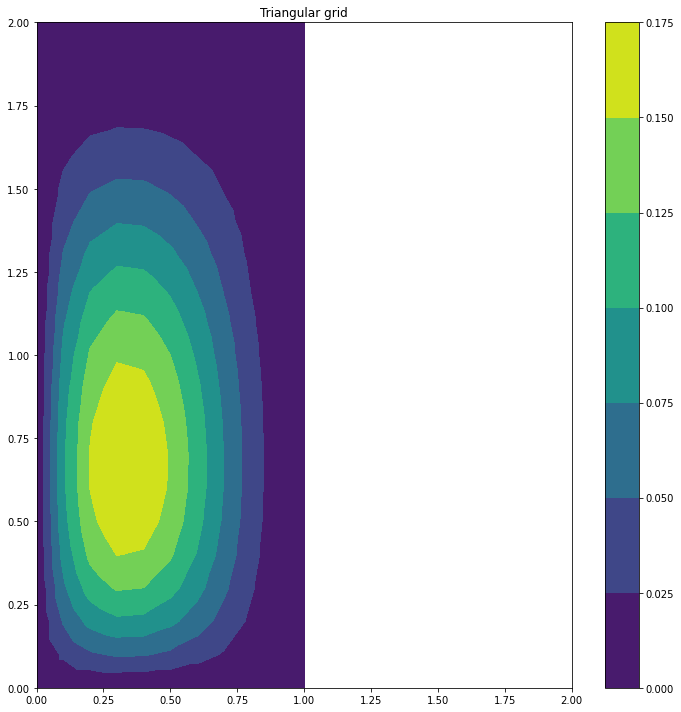

In [12]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
fig.colorbar(cp)
ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

In [13]:
def show_success(index):
    point_index = int(len(points) * index)

    print("Exact solution: \t", ex[point_index])
    print("Approximate solution: \t", *b[point_index])
    print("Error: \t\t\t", np.abs(ex[point_index] - b[point_index][0]))
    print()


In [14]:
for coef in [0, 0.1, 0.57, 0.81]:
    show_success(coef)

Exact solution: 	 0.0
Approximate solution: 	 -2.0006305694953743e-11
Error: 			 2.0006305694953743e-11

Exact solution: 	 0.052488000000000014
Approximate solution: 	 0.08158327868734978
Error: 			 0.02909527868734977

Exact solution: 	 0.10800000000000003
Approximate solution: 	 0.12936943454342767
Error: 			 0.021369434543427643

Exact solution: 	 0.0006079999999999935
Approximate solution: 	 0.03169652173996514
Error: 			 0.03108852173996515



In [15]:
# mesh = range(len(b))

# fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(mesh, ex, 'blue')
# ax.plot(mesh, b, 'red')